In [1]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import requests
import cv2

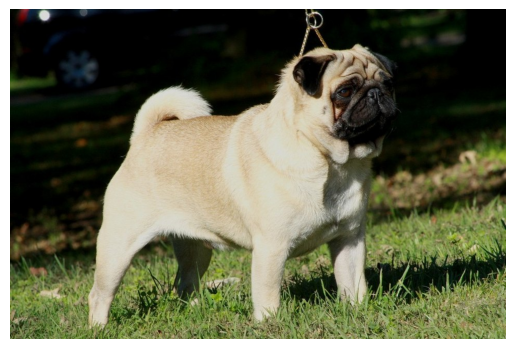

In [13]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained model
model = models.resnet50(pretrained=True)
model.to(device)
model.eval() # Set model to evaluation mode

# Download and open a sample image
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Mops-duke-mopszucht-vom-maegdebrunnen.jpg/960px-Mops-duke-mopszucht-vom-maegdebrunnen.jpg"
response = requests.get(image_url, stream=True)
img = Image.open(response.raw).convert('RGB')

# Define image transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Preprocess the image and add a batch dimension
input_tensor = preprocess(img).unsqueeze(0).to(device)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

Model's Top Prediction: pug (Index: 254)


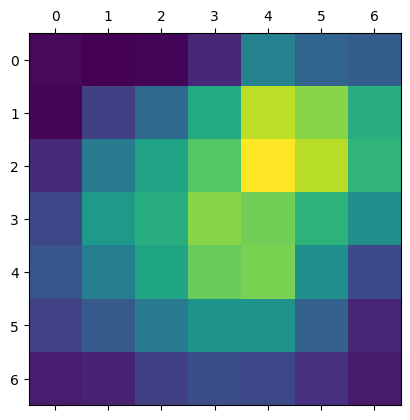

In [14]:
#store the gradients and activations in these global variables
gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

def forward_hook(module, input, output):
    global activations
    activations = output

# Register the hooks on the target layer
target_layer = model.layer4
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# Perform the forward pass
output = model(input_tensor)

# Get the top prediction index
predicted_class = torch.argmax(output).item()

# Download and load the ImageNet class labels
LABELS_URL = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
labels = requests.get(LABELS_URL).json()
predicted_class_name = labels[predicted_class]

print(f"Model's Top Prediction: {predicted_class_name} (Index: {predicted_class})")

# Use the model's actual prediction for the backward pass
target_class = predicted_class
model.zero_grad()
output[0, target_class].backward()

# Calculate the heatmap
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

heatmap = torch.mean(activations, dim=1).squeeze()
heatmap = F.relu(heatmap) # Apply ReLU
heatmap /= torch.max(heatmap) # Normalize

# Display the raw heatmap
plt.matshow(heatmap.detach().cpu())
plt.show()

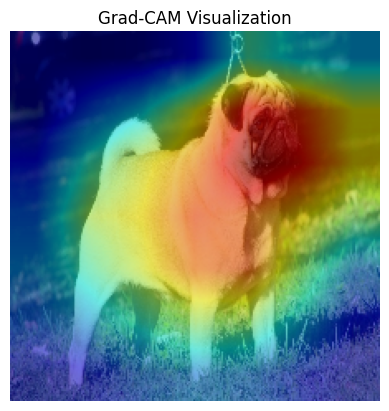

In [15]:
# Convert the original image from PIL to an OpenCV BGR format
# and resize to match the heatmap's intended dimensions
original_img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
original_img_cv = cv2.resize(original_img_cv, (224, 224))

# Detach heatmap from the computation graph, move to CPU, and convert to numpy
heatmap_np = heatmap.detach().cpu().numpy()

# Resize the heatmap to be the same size as the image
heatmap_resized = cv2.resize(heatmap_np, (224, 224))

# Convert the heatmap to a color map
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image with a 0.5 alpha weight
superimposed_img = cv2.addWeighted(original_img_cv, 0.5, heatmap_colored, 0.5, 0)

# Convert the BGR image to RGB for displaying with Matplotlib
superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

plt.imsave('grad_cam_result.png', superimposed_img_rgb)

# Display the final image
plt.imshow(superimposed_img_rgb)
plt.title("Grad-CAM Visualization")
plt.axis('off')
plt.show()